Below follows a quick demo on how the PyPole class works and some of the relevant simulations used for the paper on "Optimal Geometry". We begin by importing necessary Python packages;

In [1]:
import pyHiChi as hc #The pyHiChi module
import numpy as np
from PyPole import * #PyPole class import

Before performing any simulations we should set the simulation domain and relevant paramters for the bidipole-beam interaction. A key to the parameters are found below.

# Key to parameters #

- $R_0$; The distance away from the Bi-dipole wave focus. This is given in units of the laser wavelength.
- $P_0$; Average input power, see eq.38 of https://journals.aps.org/pra/abstract/10.1103/PhysRevA.86.053836. This is given in erg/s.
- $a_{fac}$; Adapted from https://journals.aps.org/pra/abstract/10.1103/PhysRevA.86.053836 (eq.48).
- $L_{box}$; Tuple of arrays which represent the input dimensions of the simulation box.
- number_e_real; Number of electrons that should be represented in the simulation.
- number_e; The "actual" number of electrons used in the simulation.
- electron_energy; Energy of the electron beam given in units of erg.
- beam_length; Longitudinal length of the electron beam given in units of the laser wavelength.
- spot_radius; Parameter specifying the transverse size of the electron beam, which we here take to be distributed uniformally on a cricle of radius "spot_radius". This is also given in units laser wavelength.
- thresh; Sets the resolution of the simulation domain and timestep in fractional units of the laser wavelength.

In [2]:
#Reference wavelength is 1um = 1e-4 cm (pyHiChi uses cgs-based units)
micro = 1e-4

#Necessary prefixe conversions needed for later.
femto = 1e-15

#The dimensions of the simulation box in terms of the laser wavelength!
lx = [-4, 4] 
ly = [-4, 4] 
lz = [-4, 4]

#Set up a BiPole class. Now bp can be called, using various useful functions.
bp = BiPole(wavelength=0.8*micro,
            R0 = 3.0,
            P0 = 1e+24,
            a_fac=0.2, 
            L_box=np.array([lx,ly,lz]),
            number_e_real=1e+9,
            number_e=2000,
            electron_energy=0.320435324,
            beam_length=1.0,
            spot_radius=2.0,
            thresh=1/8
            )

#Will be used later for the High-chi event rate.
laser_period = (bp.wavelength/bp.c)/femto
beam_volume = (np.pi * bp.beam_length * bp.spot_radius**2)/micro**3
ele_num_density = (bp.number_e / beam_volume)
kappa = (ele_num_density*laser_period) #Proportionality factor defined in the paper

First we create two fields; one electric dipole wave and then a magnetic dipole wave. Lastly we add them together and observe the result.

In [3]:
E_dipole = bp.init(field_geometry='e_dipole') #Initiates an electric dipole wave with the parameters defined above. By default the electric dipole axis is along y.
H_dipole = bp.init(field_geometry='h_dipole') #Initiates a magnetic dipole wave with the parameters defined above. By default the magnetic dipole axis is along x.
Bi_dipole = E_dipole+H_dipole #Add the fields together to create a bi-dipole wave. The pyHiChi framework allows field objects to be added together.
beam = bp.uniform_electron_beam() #Create a uniform electron beam. By default this is aligned with the electric dipole axis.

Note that this way of generating a bi-dipole wave is much slower than calling:
```python
bi_dipole = bp.init(field_geometry='bi_dipole')
```
but we do this as for clarity. Next we plot the bi-dipole wave in the yz-plane to illustrate the dependence;

\begin{equation}
    I_{bi-dipole} \sim \lvert \vec{E}_{bi-dipole} \lvert^2 \sim (1-\mathrm{cos}(\theta))^2
\end{equation}

The bi-dipole wave in the yz-plane


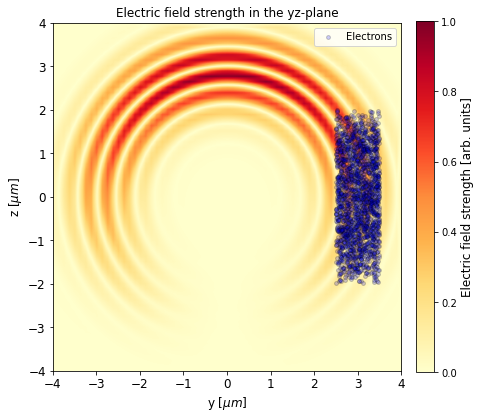

0

In [4]:
orientation = 'yz' #Default is 'xy' but 'yz' and 'xz' are also possible orientations to display.
print('The bi-dipole wave in the'+' '+orientation+'-plane')
bp.field_image(Bi_dipole, beam, fsize=12, fwidth=3.39/0.5, orientation=orientation, show_beam=True) #Visualize the bi-dipole electric field strength in the yz-plane. Here we also show the electrons whereas in the paper we do not.

In order to explore the high-$\chi$ singlet event parameter space as a function of input power $P$ and electron beam energy $\varepsilon$ we define a Python helper function to run a parametric scan as shown in the paper. Note that this can take up to 20 minutes or even more than an hour depending on how many points you need to sample. For this purpose we have already shipped NumPy arrays with pre-calculated parametric scans. They are loaded below.

In [3]:
def HiChi_surface(chi_threshold, Parray, Earray):
    n_fields = len(Parray) #Number of unique fields to create, one for each input power P.
    n_beams = len(Earray) #Number of unique electron beams to create, one for each beam energy E.
    MAP = [] #List to store the event rate.
    for N in range(n_fields):
        print('On current step', N+1, 'of', n_fields)
        #Need to generate a new instance of bp for each field, this is inconvenient and will be changed later.
        bp = BiPole(wavelength=0.8*micro,
                    R0 = 3.0,
                    P0 = Parray[N],
                    a_fac=0.2, 
                    L_box=np.array([lx,ly,lz]),
                    number_e_real=1e+9,
                    number_e=2000,
                    electron_energy=0.320435324,
                    beam_length=1.0,
                    spot_radius=2.0,
                    thresh=1/4
                    )
        bp.chi_max = chi_threshold #Change the class instance of chi*, this is solely for plotting purposes.
        field = bp.init(field_geometry='bi_dipole')
        beams = [bp.uniform_electron_beam(input_erg=Earray[M]) for M in range(n_beams)] #Generate a list of all the electron beams.
        #run_sfqed runs a simulation between the current field and all the beams while recording all the high-chi event singlets.
        MAP.append([bp.run_sfqed(field, beams[M], track_diagnostic='events', revert_field=True) for M in range(n_beams)])
    return np.array(MAP)


In [4]:
peta = 1e+15 #Petawatt prefix
pstart = 1*peta*1e+7 #Start parametric scan for P = 1PW in units of erg/s.
pstop = 1000*peta*1e+7 #Stop at 1000 PW.
estart = 1*0.00160218 #Start parametric scan for electron beam energy at 1GeV in units of erg.
estop = 1000*0.00160218#-||-
spacing = 20 #Number of points to sample, this will generate an image of size spacing X spacing.

power_array = np.linspace(pstart, pstop, spacing)
erg_array = np.linspace(estart, estop, spacing)
power_array_logspace = np.logspace(np.log10(pstart), np.log10(pstop), base=10, num=spacing) #Logspaced arrays
erg_array_logspace = np.logspace(np.log10(estart), np.log10(estop), base=10, num=spacing)

chi_threshold = np.array([50, 200, 800]) #Chi thresholds, the function HiChi_surface need to be called for each.

#WARNING; Only uncomment and run this code if you want to explore the notebook yourself. Otherwise this can be very time consuming since it is not yet optimized for performance.
#HCS_50 = HiChi_surface(chi_threshold[0], power_array, erg_array)
#HCS_200 = HiChi_surface(chi_threshold[1], power_array, erg_array)
#HCS_800 = HiChi_surface(chi_threshold[2], power_array, erg_array)

# HCS_50_log = HiChi_surface(chi_threshold[0], power_array_logspace, erg_array_logspace)
# HCS_200_log = HiChi_surface(chi_threshold[1], power_array_logspace, erg_array_logspace)
# HCS_800_log = HiChi_surface(chi_threshold[2], power_array_logspace, erg_array_logspace)

#np.savetxt('HCS_50', HCS_50)
#np.savetxt('HCS_200', HCS_200)
#np.savetxt('HCS_800', HCS_800)

# np.savetxt('HCS_50_log', HCS_50_log)
# np.savetxt('HCS_200_log', HCS_200_log)
# np.savetxt('HCS_800_log', HCS_800_log)


#Otherwise; we can load pre-calculated parametric scans. The bottom one is done in logarithmic steps.
HCS_50 = np.loadtxt('HCS_50')
HCS_200 = np.loadtxt('HCS_200')
HCS_800 = np.loadtxt('HCS_800')

# HCS_50_log = np.loadtxt('HCS_50_log')
# HCS_200_log = np.loadtxt('HCS_200_log')
# HCS_800_log = np.loadtxt('HCS_800_log')

With three parametric scans at hand we are now able to visualize this. This is built into the class instance so we can simply call a plotting function below;

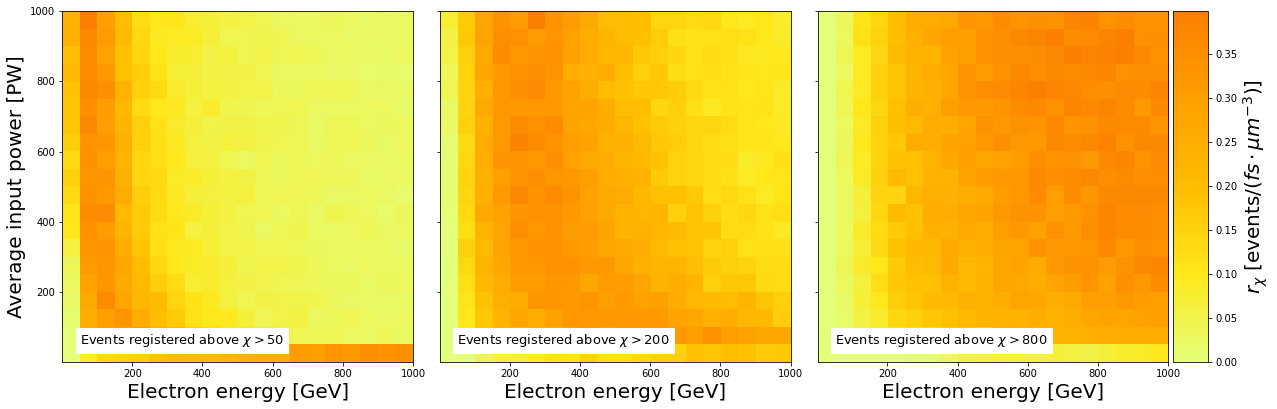

0

In [20]:
HCS_list = np.array([HCS_50, HCS_200, HCS_800])/kappa
bp.PE_imshow(HCS_list, power_array, erg_array, chi_threshold, fwidth=8.3/0.5, fsize=20)

And using logarithmic steps;

In [11]:
HCS_list_log = np.array([HCS_50_log, HCS_200_log, HCS_800_log])
bp.PE_imshow(HCS_list_log, power_array_logspace, erg_array_logspace, thresholds, fwidth=15, log_scale=True)

0.0012055370030776662


NameError: name 'HCS_50_log' is not defined